In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from costsensitive import WeightedAllPairs
import seaborn as sns


# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')#.sample(500)
test_data = pd.read_csv('./data/fashion-mnist_test.csv')#.sample(500)

# Separate features (X) and labels (y) for training and testing
X_train = train_data.iloc[:, 1:].values  
y_train = train_data.iloc[:, 0].values  

X_test = test_data.iloc[:, 1:].values    
y_test = test_data.iloc[:, 0].values  

# normalize/scale the pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Step 2: Define the misclassification cost matrix
cost_matrix = np.array([
    [0, 3, 2, 1, 2, 3, 1, 3, 3, 3],
    [3, 0, 3, 3, 3, 3, 3, 3, 3, 3],
    [2, 3, 0, 2, 1, 3, 2, 3, 3, 3],
    [1, 3, 2, 0, 2, 3, 1, 3, 3, 3],
    [2, 3, 1, 2, 0, 3, 2, 3, 3, 3],
    [3, 3, 3, 3, 3, 0, 3, 1, 3, 1],
    [1, 3, 2, 1, 2, 3, 0, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 0, 3, 1],
    [3, 3, 3, 3, 3, 3, 3, 3, 0, 3],
    [3, 3, 3, 3, 3, 1, 3, 1, 3, 0]
])
y_train_costed = np.zeros((len(y_train), cost_matrix.shape[1]))

for i, true in enumerate(y_train):
    y_train_costed[i] = cost_matrix[true]

print(y_train_costed[0])

# Step 4: Train a Random Forest Classifier using the calculated class weights
rf_clf = WeightedAllPairs(RandomForestClassifier(n_estimators=100, random_state=42))
rf_clf.fit(X_train, y_train_costed)

# Step 5: Predict on the test set
y_pred = rf_clf.predict(X_test)

[2. 3. 0. 2. 1. 3. 2. 3. 3. 3.]


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1000
           1       1.00      0.96      0.98      1000
           2       0.81      0.79      0.80      1000
           3       0.88      0.94      0.91      1000
           4       0.81      0.85      0.83      1000
           5       0.97      0.94      0.96      1000
           6       0.72      0.60      0.65      1000
           7       0.92      0.93      0.92      1000
           8       0.98      0.96      0.97      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix:
[[868   0   7  29   0   0  92   0   4   0]
 [  6 963   4  20   0   1   6   0   0   0]
 [ 19   0 787  13 115   0  63   0   3   0]
 [ 16   3   2 940  12   1  26   0   0   0]
 [  1   0  70  40 847   0  4

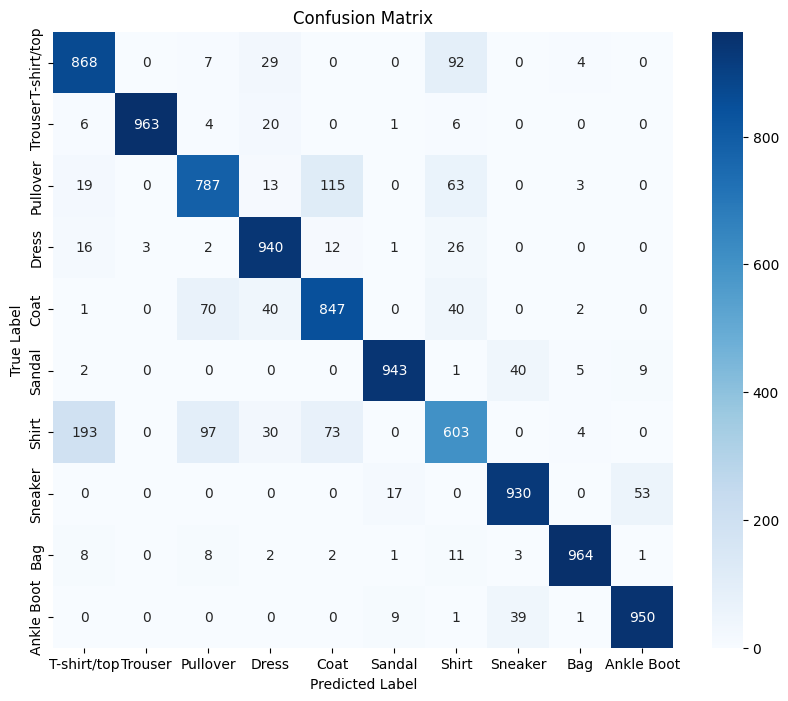

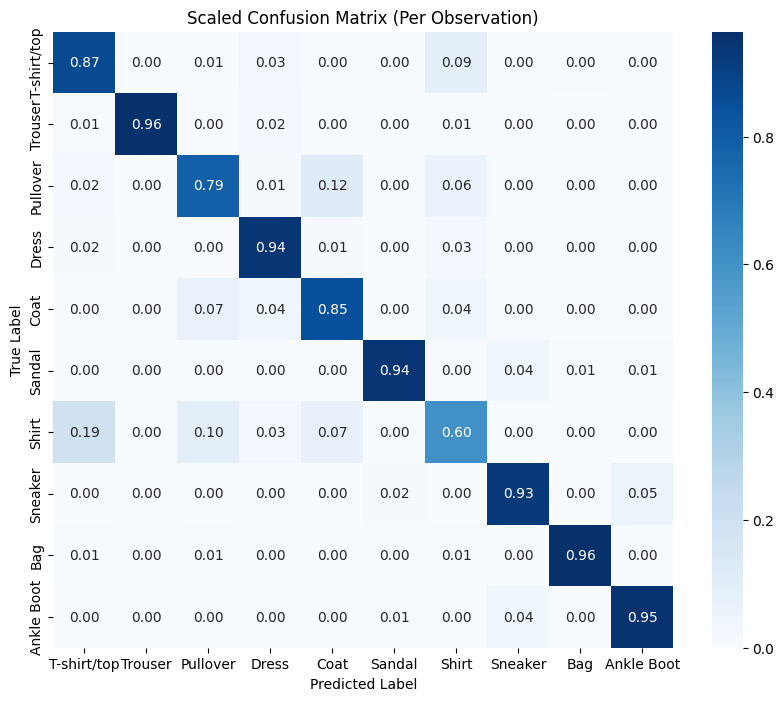

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred are already defined from your previous code

# Step 6: Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Step 7: Calculate class-specific error rates
class_specific_errors = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
print("Class-Specific Error Rates:")
print(class_specific_errors)

# Step 8: Calculate average cost using the misclassification cost matrix and confusion matrix
cost_per_class = np.zeros(len(cost_matrix))
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        cost_per_class[i] += conf_matrix[i, j] * cost_matrix[i, j]

# Average cost per observation
average_cost = np.sum(cost_per_class) / len(y_test)
print("Average Misclassification Cost:", average_cost)

# Step 9: Scaled confusion matrix (per observation from each class)
scaled_conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)
print("Scaled Confusion Matrix (per observation):")
print(scaled_conf_matrix)

# Define class names for Fashion MNIST
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot"
]

# Visualize confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Visualize scaled confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_conf_matrix, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Scaled Confusion Matrix (Per Observation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [13]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Function to calculate 95% confidence interval
def compute_confidence_interval(error_rate, n):
    return proportion_confint(count=error_rate*n, nobs=n, method='wilson')

# Overall error rate for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred)
rf_error_rate = 1 - rf_accuracy
rf_error_rate_ci = compute_confidence_interval(rf_error_rate, len(y_test))

print(f"Random Forest Overall Error Rate: {rf_error_rate:.4f}, 95% CI: {rf_error_rate_ci}")

# Class-specific error rates
rf_class_error_rates = []
mdda_class_error_rates = []

for label in np.unique(y_test):
    rf_class_accuracy = accuracy_score(y_test[y_test == label], y_pred[y_test == label])
    rf_class_error_rate = 1 - rf_class_accuracy
    rf_class_error_rate_ci = compute_confidence_interval(rf_class_error_rate, np.sum(y_test == label))
    rf_class_error_rates.append((label, rf_class_error_rate, rf_class_error_rate_ci))

# Display class-specific error rates for both models
print("Class-Specific Error Rates for Random Forest:")
for label, error_rate, ci in rf_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")

Random Forest Overall Error Rate: 0.1205, 95% CI: (0.11426471744636518, 0.12702673731697844)
Class-Specific Error Rates for Random Forest:
Class 0: Error Rate: 0.1320, 95% CI: (0.11242163614807689, 0.15439485809729173)
Class 1: Error Rate: 0.0370, 95% CI: (0.026961180875554762, 0.05058239748206935)
Class 2: Error Rate: 0.2130, 95% CI: (0.18874695684098672, 0.2394496025297219)
Class 3: Error Rate: 0.0600, 95% CI: (0.046896472675932006, 0.07647107479135662)
Class 4: Error Rate: 0.1530, 95% CI: (0.1320192156243113, 0.17663655476466406)
Class 5: Error Rate: 0.0570, 95% CI: (0.04425344035871598, 0.07313706765948597)
Class 6: Error Rate: 0.3970, 95% CI: (0.36712458560070244, 0.42766372664732194)
Class 7: Error Rate: 0.0700, 95% CI: (0.05577636414629399, 0.08751464815128329)
Class 8: Error Rate: 0.0360, 95% CI: (0.02611557140738734, 0.049435660467207876)
Class 9: Error Rate: 0.0500, 95% CI: (0.038130262392748845, 0.06531382024425086)
